# Bayesian pooled polling charts (Using PyMC)

## Set-up

In [1]:
# system imports
import itertools
from pathlib import Path
from typing import Any, TypedDict, NotRequired

import re

# analytic imports
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
from IPython.display import display


In [2]:
# local import
import bayes_tools
import plotting
from common import MIDDLE_DATE, VOTING_INTENTION, ensure
from data_capture import retrieve

In [3]:
# plotting related
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

SHOW = False  # show charts in the notebook
SHOW_MODEL_MAPS = False  # show model maps in notebook

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

conda environment: 312

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

numpy  : 1.26.4
pandas : 2.2.3
IPython: 8.31.0
re     : 2.2.1
pymc   : 5.20.0

Watermark: 2.5.0



## Get data

In [5]:
def data_check(retrieved: dict[str, Any]) -> dict:
    """Pass the latest data and check it for completeness."""

    ensure(retrieved, "You must run the data capture notebook every day.")
    vi = retrieved[VOTING_INTENTION]
    should_be_complete = ("ALP", "L/NP", "GRN", "OTH")
    check = [x for x in vi.columns if any(y in x for y in should_be_complete)]
    problematic = vi[vi[check].isnull().sum(axis=1) > 0].index
    if problematic.any():
        print(f"Problematic rows: {problematic}")
        display(vi.loc[problematic])
    return retrieved

In [6]:
def last_election() -> pd.Series:
    """Return the results of the last election."""

    previous = pd.read_csv(
        "../historic-data/election-outcomes.csv", sep="\\s+", na_values="-", comment="#"
    )
    previous = previous.dropna(how="all")
    coalition = ["LP", "LNP", "NP", "CLP"]
    previous["Primary vote L/NP"] = previous[coalition].sum(axis=1)
    previous["Primary vote Other"] = (
        100.0 - previous["Primary vote L/NP"] - previous["ALP"] - previous["GRN"]
    )
    previous["Primary vote ALP"] = previous["ALP"]
    previous["Primary vote GRN"] = previous["GRN"]
    previous["2pp vote L/NP"] = 100.0 - previous["Labor2pp"]
    previous["2pp vote ALP"] = previous["Labor2pp"]
    drop_list = [
        "Others",
        "ON",
        "UAP",
        "DEM",
        "DLP",
        "GRN",
        "ALP",
        "Labor2pp",
    ] + coalition
    return previous.drop(columns=drop_list).iloc[-1]

## Prepare for the Bayesian aggregation/pooling ...

### The selection of charts to plot

In [7]:
def select_analytic_modality() -> list[tuple[bool, str, str]]:
    # pylint: disable=unused-variable
    """
    Select the analutic modalities that will be applied
    to each column in the voting intention data.
    Returns a list of tuples. where each tuple has three
    elements:
     - fixed_prior (True, False)
     - likelihood (Normal, StudentT)
     - approach (GRW, GRWLA, GP)
    """

    # -- the analytic possibilities that can be selected
    fixed_priors = False, True
    likelihoods = "Normal", "StudentT"
    approaches = "GRW", "GRWLA", "GP"

    # -- create a range of options for the analysis
    complete_set = list(itertools.product(fixed_priors, likelihoods, approaches))
    fixed_normal_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal"
    ]
    fixed_student_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT"
    ]
    fixed_gp_only = [x for x in complete_set if x[0] and x[2] == "GP"]  # noqa: F841
    not_fixed_gp_only = [  # noqa: F841
        x for x in complete_set if not x[0] and x[2] == "GP"
    ]
    not_fixed_grw_only = [  # noqa: F841
        x for x in complete_set if not x[0] and "GRW" in x[2]
    ]
    fixed_normal_grw_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GRW"
    ]
    fixed_normal_gp_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GP"
    ]
    fixed_normal_gp_grw = list(  # noqa: F841
        set(fixed_normal_grw_only + fixed_normal_gp_only)
    )
    fixed_studentt_grw_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT" and x[2] == "GRW"
    ]
    fixed_studentt_gp_only = [  # noqa: F841
        x for x in complete_set if x[0] and x[1] == "StudentT" and x[2] == "GP"
    ]
    fixed_studentt_gp_grw = list(  # noqa: F841
        set(fixed_studentt_grw_only + fixed_studentt_gp_only)
    )

    # -- return the selected analysis option
    return fixed_normal_gp_grw  # <--- choose which of the above modalities to use

### Identify columns to analyze and plot

In [8]:
def select_columns(df: pd.DataFrame) -> tuple[str, ...]:
    # pylint: disable=unused-variable
    """Select the columns names from voting intention data we will analyze.
    Returns a tuple of column names, each of type str"""

    # -- identify the columns we will analyze ...
    frame = ("2pp", "Primary vote")
    columns = sorted([x for x in df.columns if any(item in x for item in frame)])
    majors = ("ALP", "L/NP")
    minors = ("GRN", "Other")
    to_chart = majors + minors

    # -- column options for selected_columns below
    # be careful to turn generator expressions into tuples ..
    all_columns: tuple = tuple(
        c for c in columns if any(item in c for item in to_chart)
    )
    alp_only = tuple(c for c in all_columns if "ALP" in c)  # noqa: F841
    lnp_only = tuple(c for c in all_columns if "L/NP" in c)  # noqa: F841
    tpp_only = tuple(f"2pp vote {x}" for x in majors)  # noqa: F841
    primary_only = tuple(x for x in all_columns if frame[1] in x)  # noqa: F841
    alp_2pp_only = ("2pp vote ALP",)  # noqa: F841
    most_columns = alp_2pp_only + primary_only  # noqa: F841
    minors_pv_only = tuple(f"Primary vote {x}" for x in minors)  # noqa: F841
    majors_pv_only = tuple(f"Primary vote {x}" for x in majors)  # noqa: F841

    # -- return the selected columns
    return all_columns  # <--- choose which of the above variables to return

### Fixed Priors

In [9]:
def establish_fixed_priors() -> dict[str, Any]:
    """Return a dictionary of fixed priors."""

    # a useful bag of fixed priors
    assumed_sample_size = 750  # assume smallish effective sample
    # sizes polling data is way noisier
    # than published sample size suggest.
    return {
        # --- GRW only fixed priors
        "innovation": 0.175,  # only used with GRW
        # --- GP only fixed priors
        "length_scale": 40,
        "eta": 1.6,
        # --- both GP and GRW fixed priors
        "nu": 10,  # used in StudentT likelihood
        "sigma_likelihood": np.sqrt((50.0 * 50.0) / assumed_sample_size),
    }

### Exclusions from the sum-to-zero constraint on house effects

In [10]:
EXCLUDE = True


def establish_exclusions(df: pd.DataFrame, minimum_polls=5) -> list[str]:
    """Return a a list of pollsters to exclude from the sum-to-zero
    constraint over house effects. Pollsters are excluded because they
    have too few polls to be reliable or because they have multiple
    series of polls that are not consistent with each other.
    Arguments:
    - df - the dataframe of the latest polling data
    Returns:
    - a list of pollsters to exclude."""

    exclusions: list[str] = []
    if not EXCLUDE:
        return exclusions

    # -- remove with multiple series (indicated by trailing digits)
    pollsters = df["Brand"].unique()
    pattern = re.compile(r"([^\d]+) (\d+$)")
    for pollster in pollsters:
        if m := re.search(pattern, pollster):
            exclusions.append(m.groups()[0])
        # Note: need to do case where the trailing digit is 3 or greater
    exclusions = list(set(exclusions))

    # -- exclude pollsters with less than minimum_polls
    # This means odd, one-off polls will not effect the positioning
    # of the poll aggregation
    pollster_counts = df["Brand"].value_counts()
    exclude_counts = pollster_counts[pollster_counts < minimum_polls].index.tolist()
    exclusions = list(set(exclusions + exclude_counts))  # ensue no duplicates

    return exclusions

### Sampler settings

In [11]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sample_settings() -> tuple[SampleSettings, SampleSettings]:
    """Return the settings for sampling as a tuple
    of two elements:
    - a dict of settings for the sampling (GRW and GP models)
    - a dict of settings for the sampling (GRWLA model)."""

    # -- for GRW and GP
    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 1_500,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    # -- for GRWLA model, as above with the following chnges
    anchored_settings = settings.copy()
    anchored_settings["draws"] = 5_000  # draws per core
    anchored_settings["nuts"] = {"max_treedepth": 12}

    return settings, anchored_settings

## Do the analysis and produce the plots

In [12]:
def plot_medians(
    medians: dict[str, pd.Series],
    orig_series: pd.Series,
    column: str,
    **kwargs: Any,
) -> dict[str, pd.Series]:
    """Plot all the medians for the same column of input data
    for the selected modes of analysis.
    Add a localised regression to the plots.
    This allows for a simple model comparison
    Returns the dictionary of medians."""

    if not medians:
        # nothing to plot
        return {}

    # -- Add a local regression to the combined plot
    period_days = 150  # days
    loess = plotting.calculate_lowess(
        series=orig_series,
        frac_period=period_days,
    )
    if loess is not None:
        medians[f"{period_days}-day local regression"] = loess

    # -- plot the medians
    _, ax = plotting.initiate_plot()
    styles = plotting.STYLES * 4
    for index, (name, m_series) in enumerate(medians.items()):
        m_series.plot(ax=ax, ls=styles[index], lw=2, label=name)
    ax.axhline(
        y=kwargs["previous_election"][column],
        color="#555555",
        lw=0.75,
        ls="--",
        label="Previous election",
    )
    ax.legend(loc="best", fontsize="xx-small", ncols=2)
    plotting.finalise_plot(
        ax,
        title=f"Comparison of medians: {column}",
        ylabel="Per cent",
        y50=True,
        concise_dates=True,
        straighten_tl=True,
        **plotting.footers,
        show=SHOW,
    )

    return medians

In [13]:
def build_model(
    column: str,
    data: pd.DataFrame,
    approach: str,
    likelihood: str,
    fixed_priors: bool,
    **kwargs: Any,
) -> None | tuple[pm.Model, SampleSettings, dict[str, Any]]:
    """Build the model for the selected approach and likelihood.
    Returns either;
    - None (on errror), or
    - the model, the sampling parameters, and the inputs"""

    # -- get the relevant data then select and run the model
    # Note: I could not get the GRW to mix well without specifying innovation.
    #       Similarly, specifying sigma_likelihood is useful.
    keep_fixed = ("innovation", "sigma_likelihood")
    fpd = kwargs["fixed_priors_dict"]
    priors = fpd.copy() if fixed_priors else {x: fpd[x] for x in keep_fixed}
    sampling = (
        kwargs["anchored_sample_args"].copy()
        if approach == "GRWLA"
        else kwargs["sample_args"].copy()
    )

    inputs = bayes_tools.prepare_data_for_analysis(
        data,
        column,
        jitter_dates=(approach == "GRWLA"),
        tail_centred=10 if approach == "GRWLA" else None,
        he_sum_exclusions=kwargs["he_sum_exclusions"],
        verbose=False,
    )

    match approach:
        case "GP":
            model = bayes_tools.gp_model(
                inputs,
                **priors,
                likelihood=likelihood,
                grw=False,
                eta_prior="HalfCauchy",  # only used if eta not in **priors
            )
        case "GRW":
            model = bayes_tools.grw_model(inputs, **priors, likelihood=likelihood)
        case "GRWLA":
            model = bayes_tools.grw_la_model(inputs, **priors, likelihood=likelihood)
        case _:
            print(f"Unknown approach: {approach}")
            return None

    return (model, sampling, inputs)

In [14]:
def apply_analyses_to_column(
    column: str,
    analysis_list: list[tuple[bool, str, str]],
    data: pd.DataFrame,
    **kwargs: Any,
) -> dict[str, float]:
    """Loop through the selected analyses for a specified column.
    For each: generate the model, draw samples, and plot the
    results. Finally, plot the medians for all the analyses.
    Returns dict of endpoints of the medians for the analysis."""

    median_sets = {}
    decoder = {
        "GRW": "Gaussian Random Walk",
        "GRWLA": "Gaussian Random Walk with Left Anchoring",
        "GP": "Gaussian Process",
    }
    for fixed_priors, likelihood, approach in analysis_list:
        fixed_text = "fixed" if fixed_priors else "free"
        model_title = f"{column} ({approach} {likelihood} {fixed_text})"
        model_name = (
            f"{decoder[approach]} - {likelihood} likelihood - {fixed_text} priors"
        )
        print(model_title)

        built = build_model(column, data, approach, likelihood, fixed_priors, **kwargs)
        if built is None:
            continue
        model, sampling, inputs = built
        bayes_tools.generate_model_map(
            model=model,
            filemame_stem=model_title,
            model_dir=MODEL_DIR,
            display_images=SHOW_MODEL_MAPS,
        )

        idata, glitches = bayes_tools.draw_samples(model, **sampling)

        middle = bayes_tools.plot_std_set(
            inputs,
            idata,
            kwargs["previous_election"][column],
            title_stem=model_title,
            glitches=glitches,
            residuals=kwargs["plot_residuals"],
            show=SHOW,
        )
        if middle is not None:
            median_sets[model_name] = middle

    # -- summary plot for each column
    orig_series: pd.Series = pd.Series(data[column].values, index=data[MIDDLE_DATE])
    median_sets = plot_medians(median_sets, orig_series, column, **kwargs)
    return {k: round(v.iloc[-1], 2) for k, v in median_sets.items()}

In [15]:
def analyse_columns(
    column_list: tuple[str, ...],
    analysis_list: list[tuple[bool, str, str]],
    data: pd.DataFrame,
    **kwargs: Any,
) -> None:
    """Loop over the columns selected for analysis.
    For each column apply the selected analyses."""

    end_points = {}
    for column in column_list:
        end_points[column] = apply_analyses_to_column(
            column, analysis_list, data, **kwargs
        )

    # the much needed table of results
    ep_table = pd.DataFrame(end_points)
    display(ep_table)
    print(ep_table.to_html())

## Run the models

2pp vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3098.0
Divergences: 0


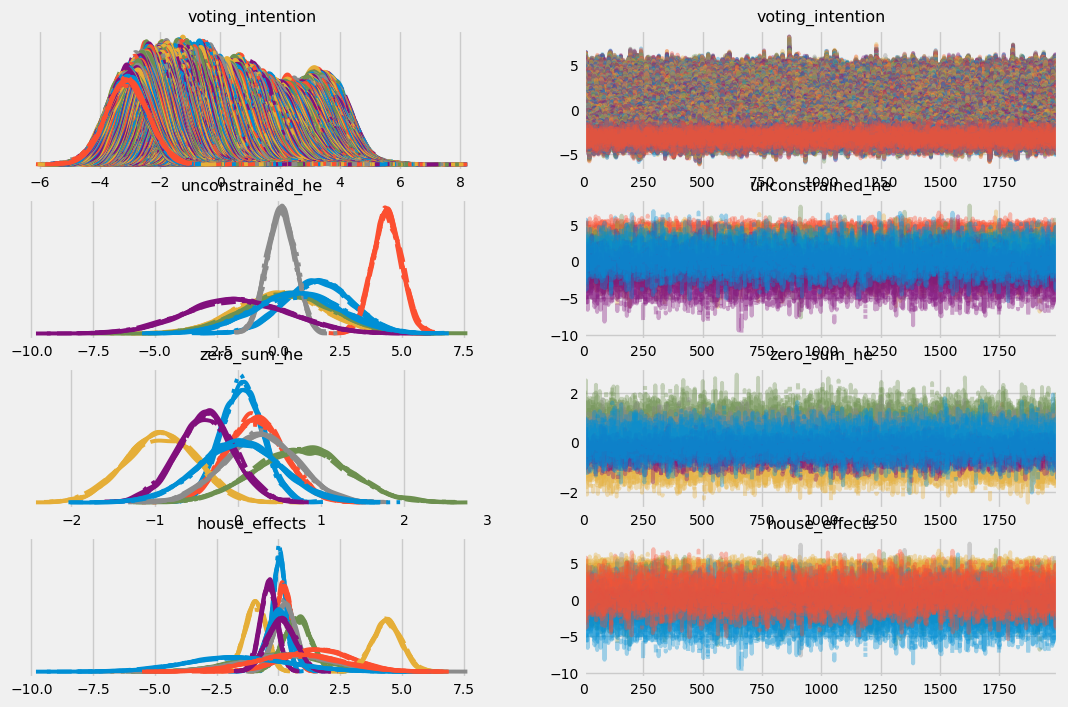

2pp vote ALP (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5432.0
Divergences: 0


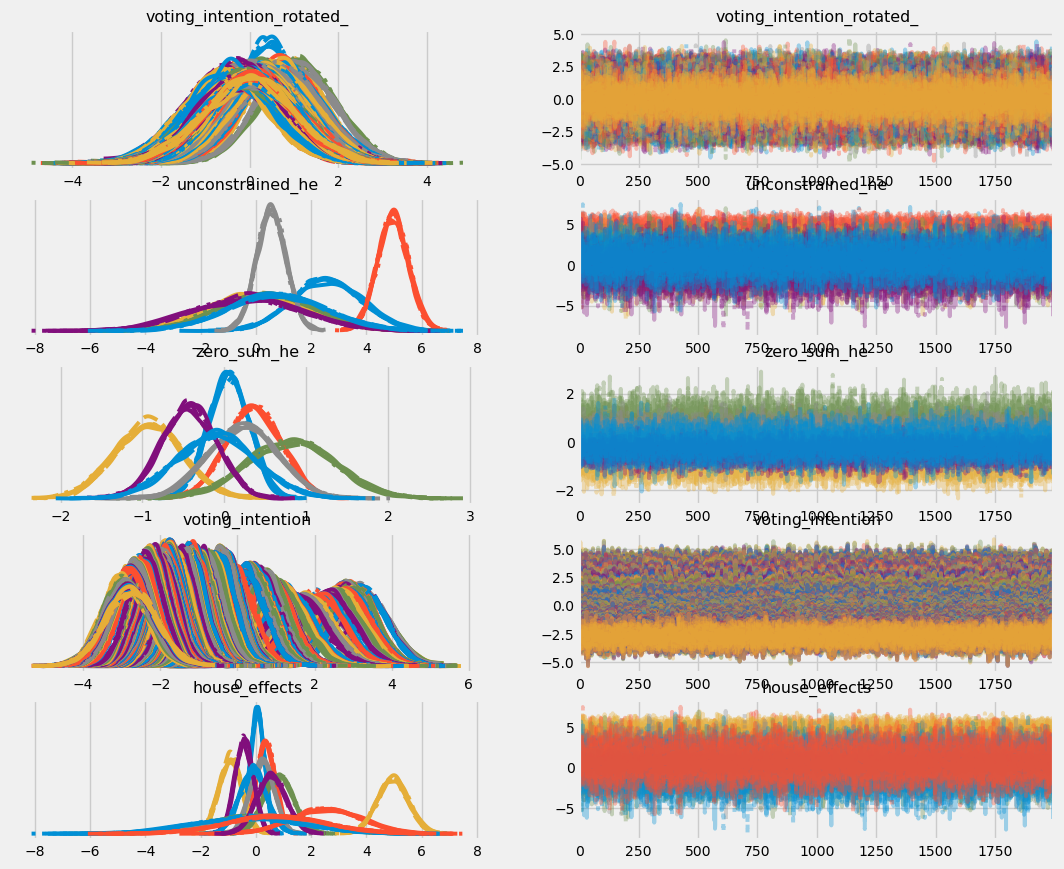

2pp vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3228.0
Divergences: 0


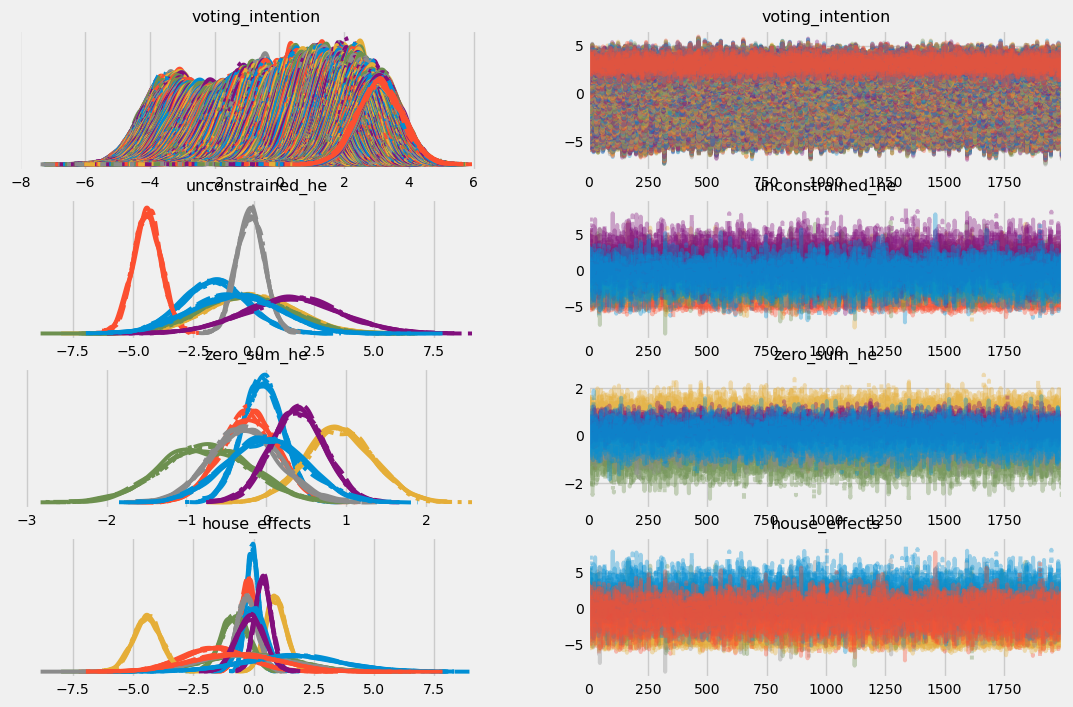

2pp vote L/NP (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5847.0
Divergences: 0


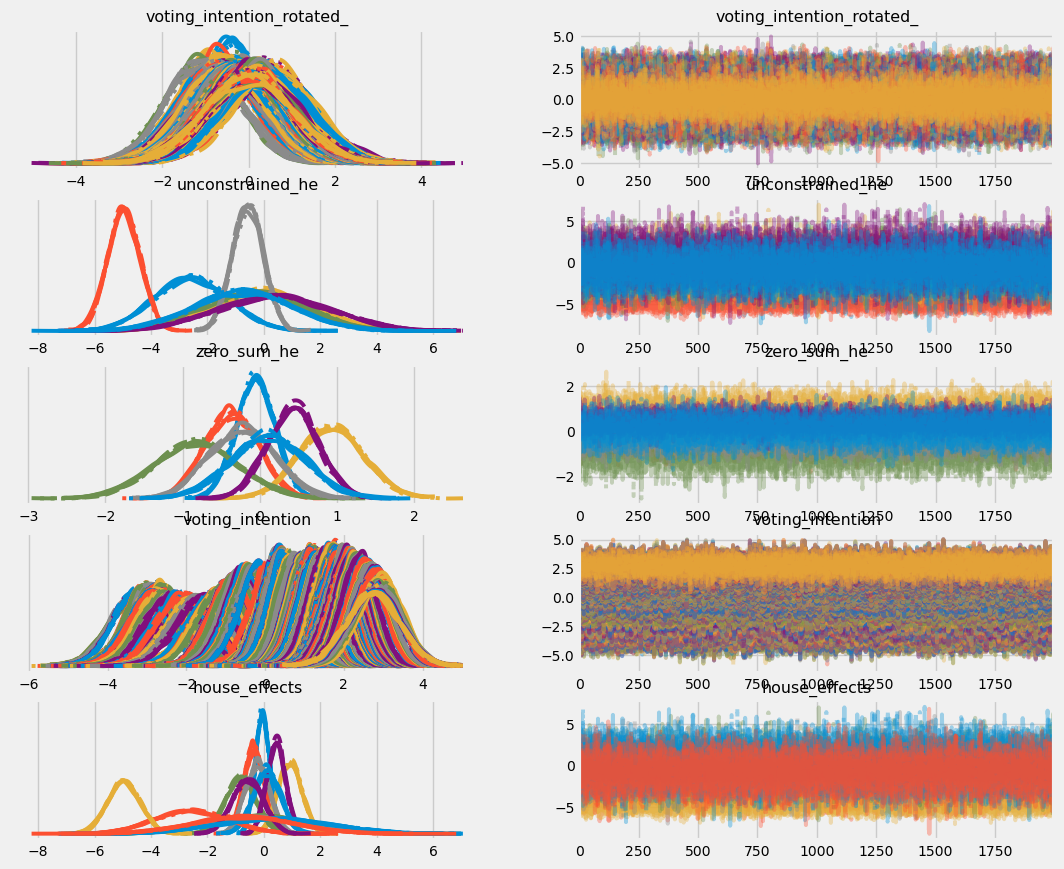

Primary vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3289.0
Divergences: 0


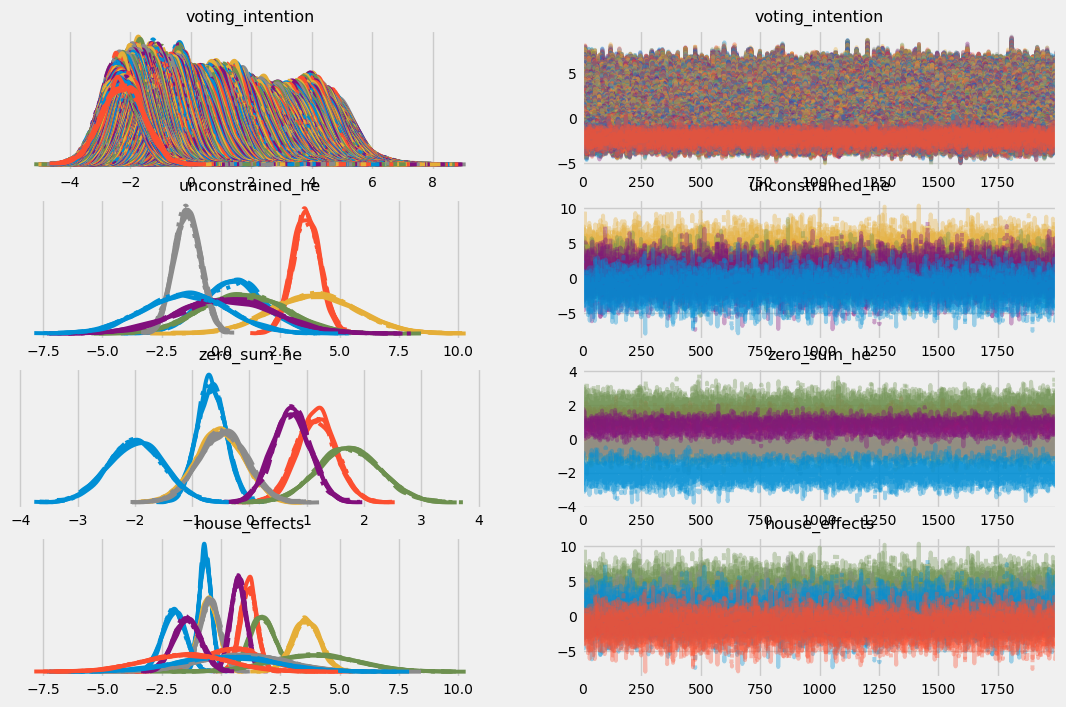

Primary vote ALP (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5540.0
Divergences: 0


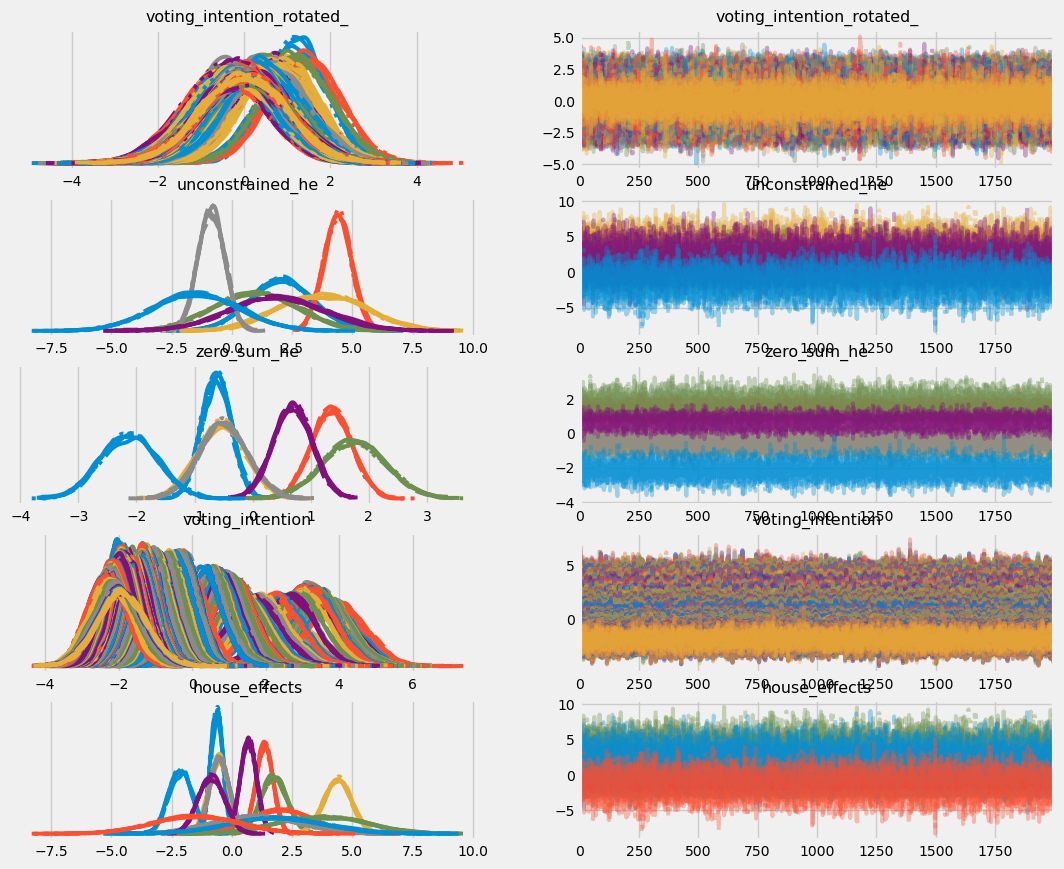

Primary vote GRN (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2417.0
Divergences: 0


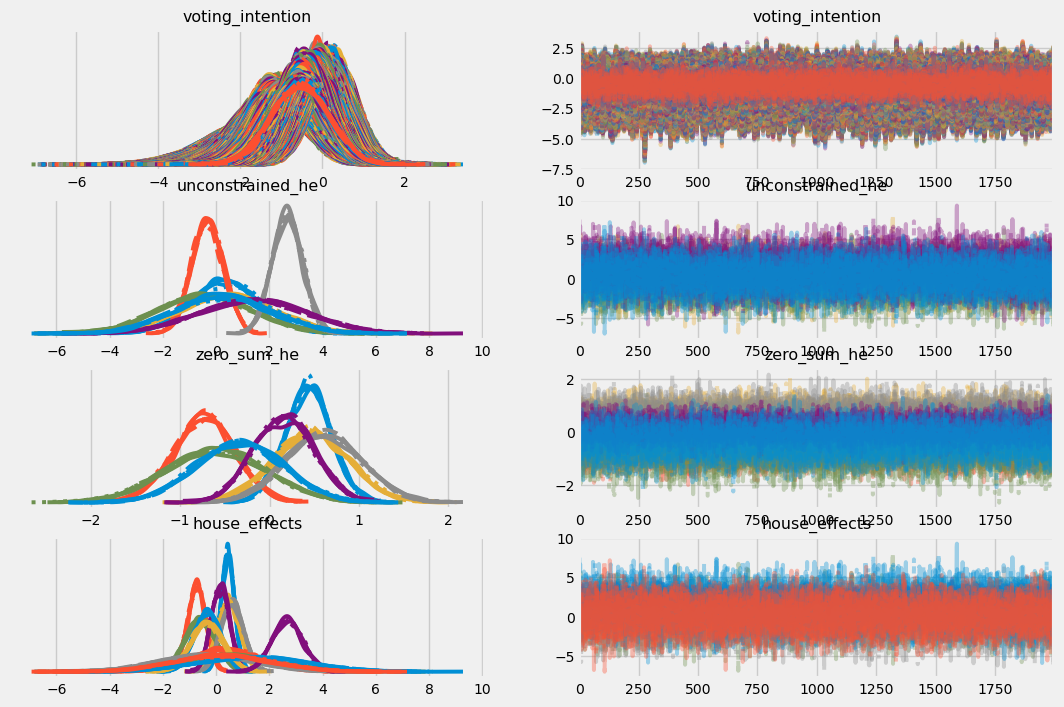

Primary vote GRN (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5829.0
Divergences: 0


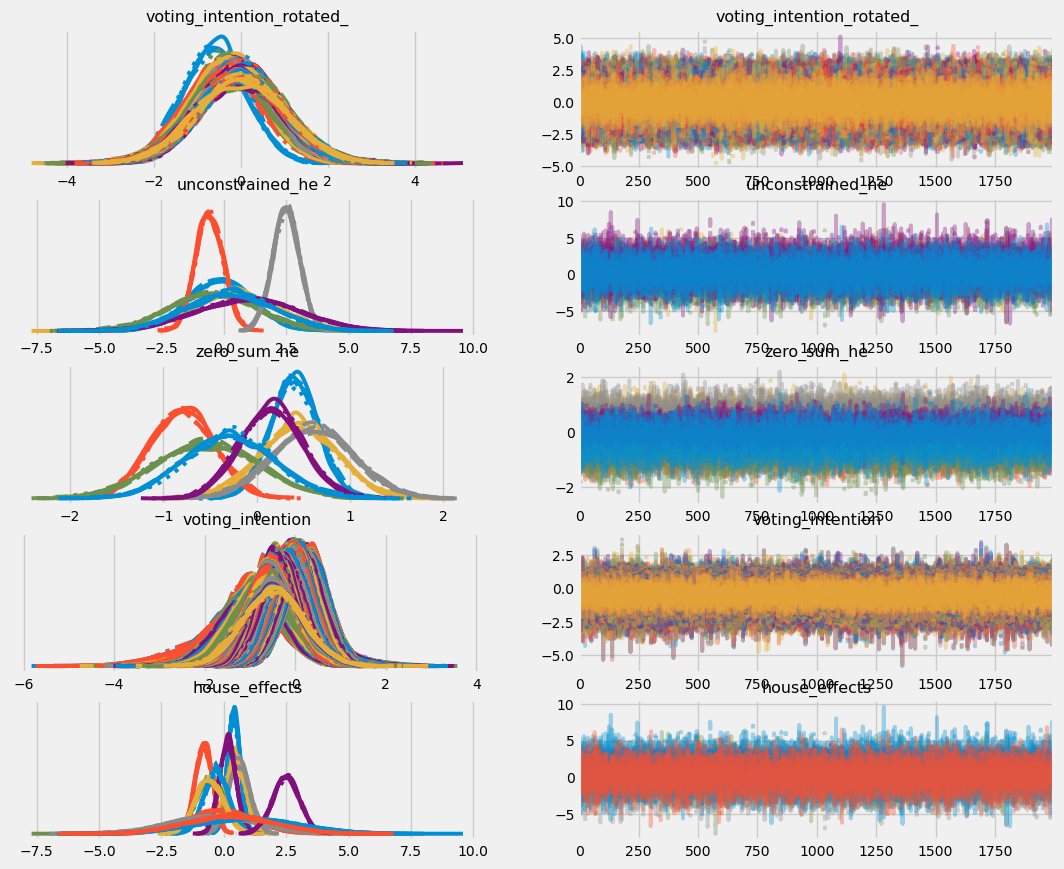

Primary vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2873.0
Divergences: 0


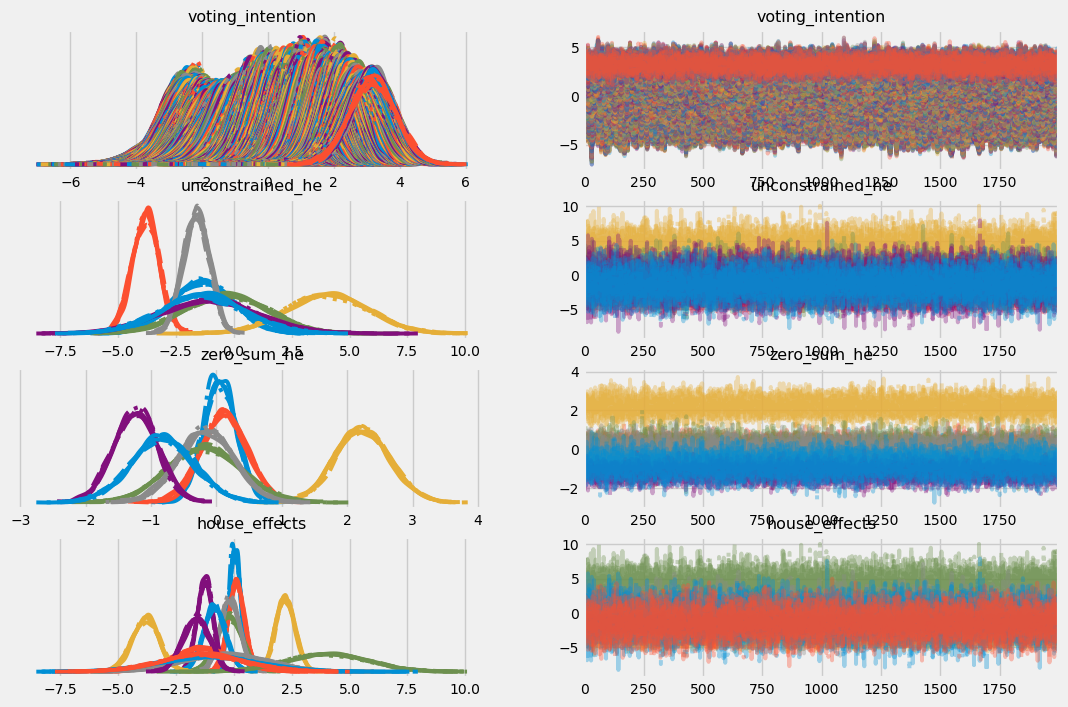

Primary vote L/NP (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5673.0
Divergences: 0


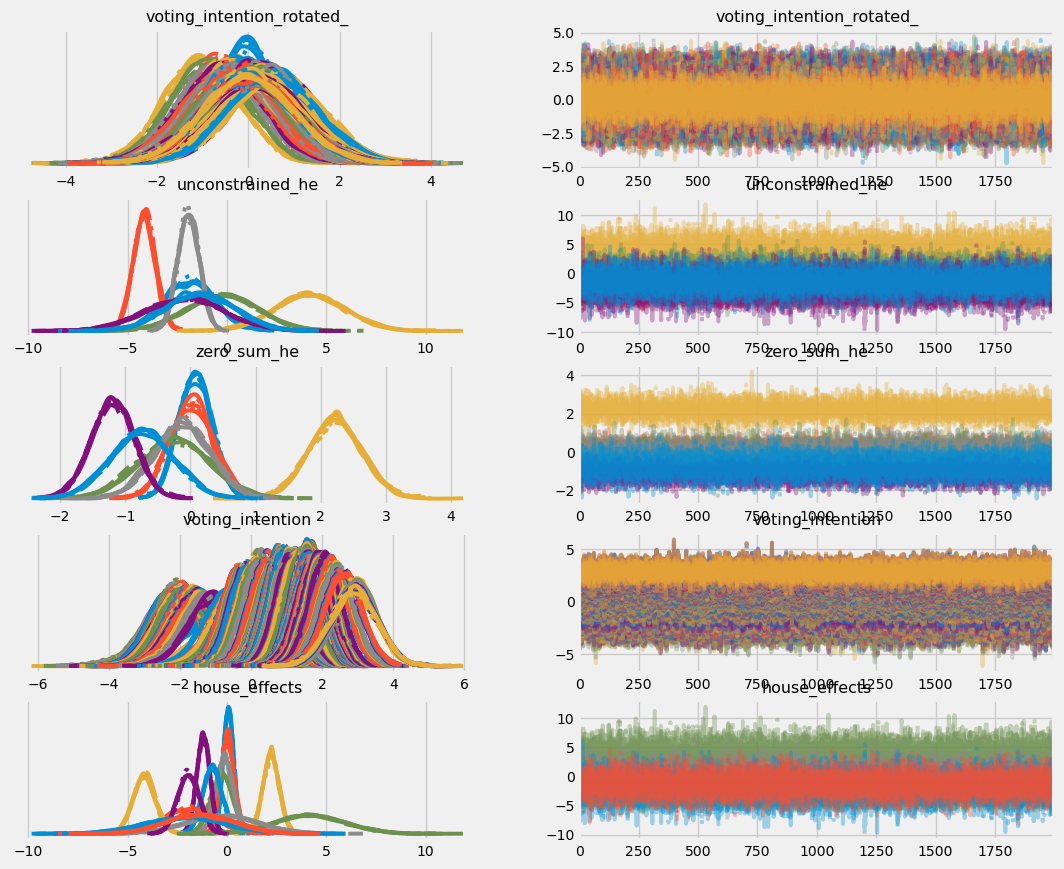

Primary vote Other (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 3377.0
Divergences: 0


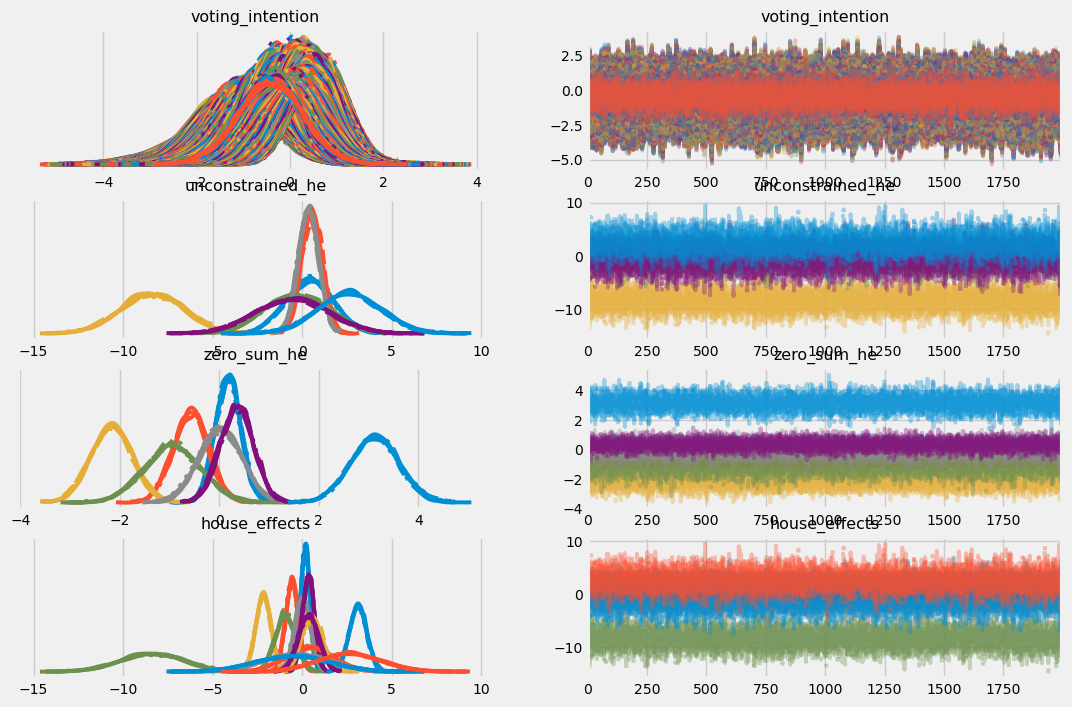

Primary vote Other (GP Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 5738.0
Divergences: 0


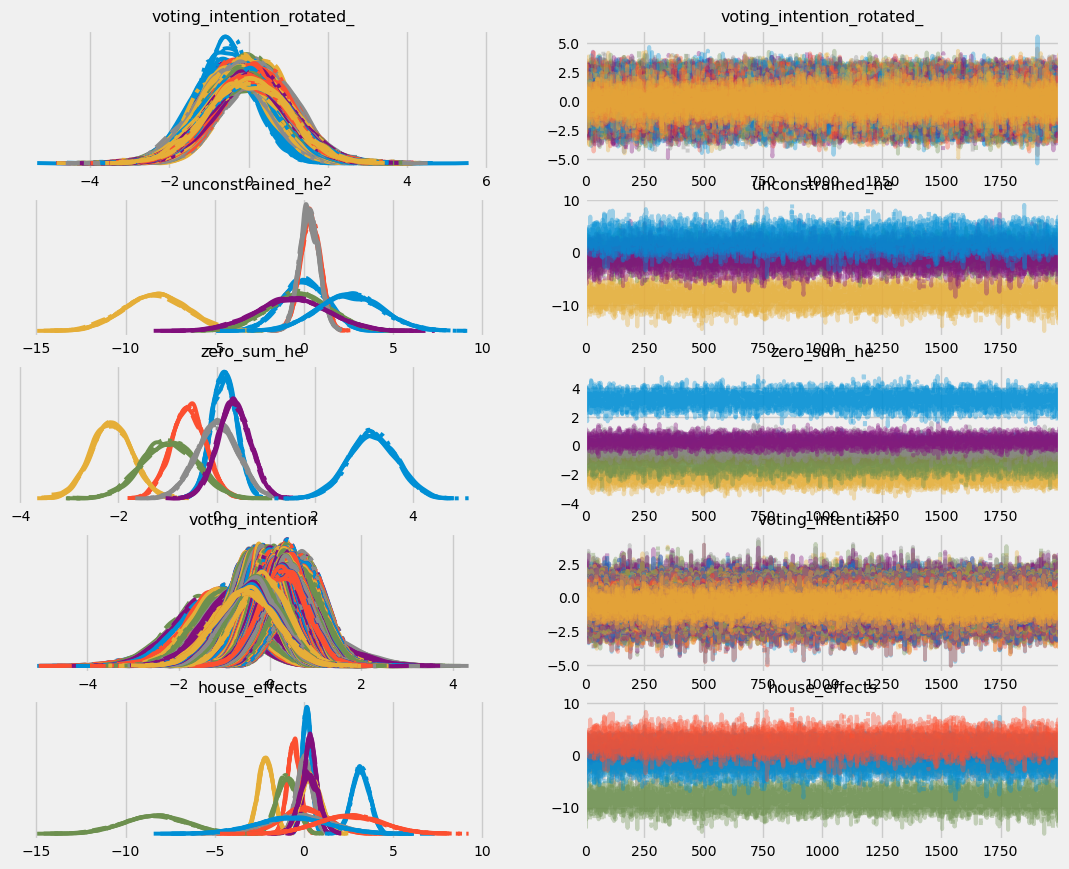

2pp vote ALP  \
Gaussian Random Walk - Normal likelihood - fixe...         48.82   
Gaussian Process - Normal likelihood - fixed pr...         49.18   
150-day local regression                                   48.42   

                                                    2pp vote L/NP  \
Gaussian Random Walk - Normal likelihood - fixe...          51.16   
Gaussian Process - Normal likelihood - fixed pr...          50.82   
150-day local regression                                    51.58   

                                                    Primary vote ALP  \
Gaussian Random Walk - Normal likelihood - fixe...             30.67   
Gaussian Process - Normal likelihood - fixed pr...             31.02   
150-day local regression                                       30.18   

                                                    Primary vote GRN  \
Gaussian Random Walk - Normal likelihood - fixe...             12.40   
Gaussian Process - Normal likelihood - fixed pr...             12.46   
150-day local regression                                       12.65   

                                                    Primary vote L/NP  \
Gaussian Random Walk - Normal likelihood - fixe...              39.39   
Gaussian Process - Normal likelihood - fixed pr...              39.10   
150-day local regression                                        39.81   

                                                    Primary vote Other  
Gaussian Random Walk - Normal likelihood - fixe...               17.53  
Gaussian Process - Normal likelihood - fixed pr...               17.41  
150-day local regression                                         16.52

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>2pp vote ALP</th>
      <th>2pp vote L/NP</th>
      <th>Primary vote ALP</th>
      <th>Primary vote GRN</th>
      <th>Primary vote L/NP</th>
      <th>Primary vote Other</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Gaussian Random Walk - Normal likelihood - fixed priors</th>
      <td>48.82</td>
      <td>51.16</td>
      <td>30.67</td>
      <td>12.40</td>
      <td>39.39</td>
      <td>17.53</td>
    </tr>
    <tr>
      <th>Gaussian Process - Normal likelihood - fixed priors</th>
      <td>49.18</td>
      <td>50.82</td>
      <td>31.02</td>
      <td>12.46</td>
      <td>39.10</td>
      <td>17.41</td>
    </tr>
    <tr>
      <th>150-day local regression</th>
      <td>48.42</td>
      <td>51.58</td>
      <td>30.18</td>
      <td>12.65</td>
      <td>39.81</td>
      <td>16.52</td>
    </tr>
  </tbody>
</table>


In [16]:
def run():
    """Run the analysis."""

    # main arguments
    data_dict = data_check(retrieve())
    vi_data = plotting.amalgamate_other(
        df=data_dict[VOTING_INTENTION]
    )  # important for establishing the "Others" category
    selected_analysis = select_analytic_modality()
    selected_columns = select_columns(vi_data)

    # additional arguments
    sample_args, anchored_sample_args = sample_settings()

    analyse_columns(
        selected_columns,
        selected_analysis,
        vi_data,
        previous_election=last_election(),
        fixed_priors_dict=establish_fixed_priors(),
        sample_args=sample_args,
        anchored_sample_args=anchored_sample_args,
        he_sum_exclusions=establish_exclusions(vi_data),
        plot_residuals=False,
    )


run()

## Finished

In [17]:
print("Finished")

Finished
